In [1]:
import sqlite3 as sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
albums_to_purchase = '''
select g.name genre,
   count(il.invoice_line_id) tracks_sold,
   cast(count(il.invoice_line_id) as float) / (
                                select COUNT(*)    from invoice_line il1 inner join invoice inv1 on inv1.invoice_id = il1.invoice_id
                          inner join customer cust1 on cust1.customer_id = inv1.customer_id
   where cust1.country = 'USA'
																							) percentage_sold
from invoice_line il 
inner join track t on t.track_id = il.track_id
inner join genre g on g.genre_id = t.genre_id
inner join invoice inv on inv.invoice_id = il.invoice_id
inner join customer cust on cust.customer_id = inv.customer_id
where cust.country = 'USA'
group by 1
order by 2 desc
limit 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


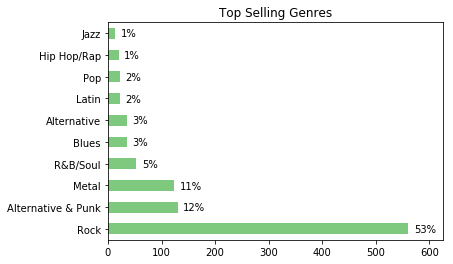

In [6]:
album_to_purch = run_query(albums_to_purchase)
album_to_purch.set_index("genre", inplace=True, drop=True)

album_to_purch["tracks_sold"].plot.barh(
    title="Top Selling Genres",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

for i, label in enumerate(list(album_to_purch.index)):
    score = album_to_purch.loc[label, "tracks_sold"]
    label = (album_to_purch.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.ylabel('')
plt.show()

In [7]:
album_to_purch.loc[(album_to_purch.index == 'Hip Hop/Rap') |
                   (album_to_purch.index == 'Alternative & Punk') |
                   (album_to_purch.index == 'Pop') |
                   (album_to_purch.index == 'Blues')
                  ]['percentage_sold']*100

genre
Alternative & Punk    12.369172
Blues                  3.425309
Pop                    2.093245
Hip Hop/Rap            1.902950
Name: percentage_sold, dtype: float64

# Analyzing Sales by Emploeee

In [13]:
q2 = '''
select e.employee_id, 
       e.first_name||' '||e.last_name as emploee_name,
       e.hire_date,
       sum(ince.total) as total_sales
  from employee e inner join customer cust on cust.support_rep_id = e.employee_id
                    inner join invoice ince on ince.customer_id = e.employee_id
    group by e.employee_id
order by 4 desc
'''


sales_by_enploee = run_query(q2)

sales_by_enploee

,employee_id,emploee_name,hire_date,total_sales
0,5,Steve Johnson,2017-10-17 00:00:00,2601.72
1,3,Jane Peacock,2017-04-01 00:00:00,2099.79
2,4,Margaret Park,2017-05-03 00:00:00,1445.40


# Visualyzing Sales by Emploeee

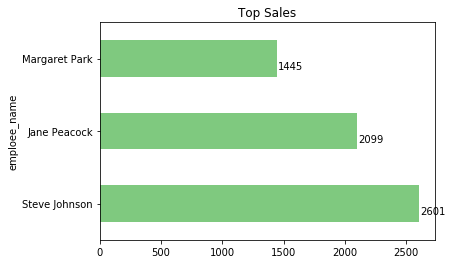

In [14]:
sales_by_enploee.plot.barh(
    x="emploee_name", y="total_sales",
    title="Top Sales",
    legend = False,
    colormap=plt.cm.Accent
)

for i, label in enumerate(list(sales_by_enploee.index)):
    score = sales_by_enploee.loc[label, "total_sales"]
    label = (sales_by_enploee.loc[label, "total_sales"]
            ).astype(int).astype(str)
    plt.annotate(str(label), (score + 10, i - 0.15))



plt.show()

# Analyzing Sales by Country

In [18]:
q3 = '''
select country_other,
       count(distinct customer_id) customers,
			 sum(unit_price) total_sales,
       sum(unit_price) / count(distinct customer_id) customer_lifetime_value,
       sum(unit_price) / count(distinct invoice_id) average_order,			 
			 case when country_other = "Other" then 1
						else 0
			 end as sort 
			 
  from (
					select c.customer_id,
								 c.country,
								 case 
										when (select count(*) from customer where country = c.country) = 1 then "Other"
										else c.country
								 end as country_other,
							 il.* 
						from invoice_line il 
						 inner join invoice inv on inv.invoice_id = il.invoice_id
						 inner join customer c on c.customer_id = inv.customer_id
     )
		 group by country_other
		 order by sort, country_other
'''


sales_by_country = run_query(q3)
sales_by_country.set_index("country_other", drop=True, inplace=True)
sales_by_country

,customers,total_sales,customer_lifetime_value,average_order,sort
country_other,,,,,
Brazil,5,427.68,85.536000,7.011148,0
Canada,8,535.59,66.948750,7.047237,0
Czech Republic,2,273.24,136.620000,9.108000,0
France,5,389.07,77.814000,7.781400,0
Germany,4,334.62,83.655000,8.161463,0
India,2,183.15,91.575000,8.721429,0
Portugal,2,185.13,92.565000,6.383793,0
USA,13,1040.49,80.037692,7.942672,0
United Kingdom,3,245.52,81.840000,8.768571,0


# Visualyzing Sales by Country